<a href="https://colab.research.google.com/github/ykitaguchi77/YOLACT_Mobius/blob/main/YOLOv%EF%BC%98_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mobius_dataset --> YOLOv8 instance segmentation training**

2024研究室配属（鈴木くん、北口くん）

```
To do：

Mobiusのマスク画像をYOLOv8形式のテキストファイルに

マスク画像がない画像を除外

YOLOv8用のフォルダ構成に
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**COCO_json形式への変換**

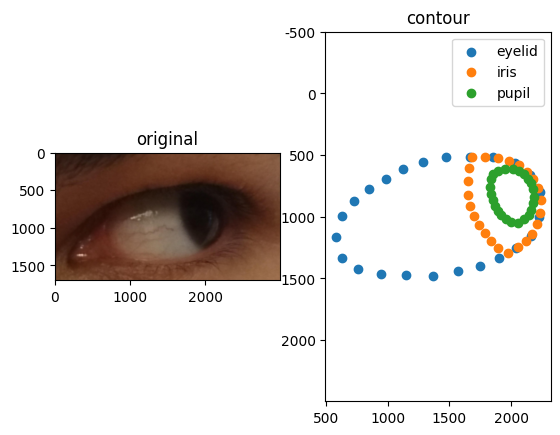

In [2]:
import cv2
import numpy as np
import json
from skimage import measure
import os
from google.colab import drive
import matplotlib
from matplotlib import pyplot as plt


def create_mask(image, color):
    return np.all(image == color, axis=-1)


def apply_mask(image, mask):
    return np.where(mask, 255, 0)


def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list


def create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, img_path, img_data, img_height, img_width):
    data = {
        "version": "5.4.1",
        "flags": {},
        "shapes": [],
        "imagePath": img_path,
        "imageData": img_data,
        "imageHeight": img_height,
        "imageWidth": img_width
    }

    data["shapes"].append({
        "label": "eyelid",
        "points": points_list_all_colors,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "iris",
        "points": points_list_blue_green,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "pupil",
        "points": points_list_blue,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    with open(json_name, 'w') as fw:
        json.dump(data, fw, indent=2)


def main(mask_file, json_name):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points)
    points_list_blue_green = extract_contours(img_blue_green, num_points)
    points_list_all_colors = extract_contours(img_all_colors, num_points)

    create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, mask_file, "/9", img_height, img_width)

#マスクされた画像のパスを指定してください。
mask_file = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks/1/1_1i_Ll_1.png"
json_name = "/content/output.json"

#輪郭点の個数を指定してください。
num_points = 24

if __name__ == '__main__':
    main(mask_file, json_name)

# 元画像と輪郭の比較
matplotlib.rcParams['axes.unicode_minus'] = False
with open('/content/output.json') as f:
    data = json.load(f)

points_eyelid = []
points_iris = []
points_pupil = []
for shape in data['shapes']:
    if shape['label'] == 'eyelid':
        points_eyelid += shape['points'][0]
    elif shape['label'] == 'iris':
        points_iris += shape['points'][0]
    elif shape['label'] == 'pupil':
        points_pupil += shape['points'][0]


x_eyelid = [point[0] for point in points_eyelid]
y_eyelid = [point[1] for point in points_eyelid]

x_iris = [point[0] for point in points_iris]
y_iris = [point[1] for point in points_iris]

x_pupil = [point[0] for point in points_pupil]
y_pupil = [point[1] for point in points_pupil]

# 元の画像を読み込む
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images/1/1_1i_Ll_1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# 図の左隣に元の画像を表示する
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("original")

# 図の右隣に散布図を表示する
plt.subplot(1, 2, 2)
plt.scatter(x_eyelid, y_eyelid, label='eyelid')
plt.scatter(x_iris, y_iris, label='iris')
plt.scatter(x_pupil, y_pupil, label='pupil')
plt.title("contour")#輪郭

# 縦横の縮尺を同じにする
plt.axis('equal')

# 縦軸を降順にする
plt.gca().invert_yaxis()

# 凡例を表示する
plt.legend()

# 図を表示する
plt.show()



In [ ]:
#保存する場合(gdrive内にあたらしくフォルダを作ってコピー
# os.makedirs('/content/drive/MyDrive/AI_laboratory_course/YOLACT_Mobius_ocular_dataset/json/ex', exist_ok=True)
# !cp output.json /content/drive/MyDrive/AI_laboratory_course/YOLACT_Mobius_ocular_dataset/json/ex/

In [4]:
import os
from tqdm import tqdm

def process_images(mask_dir, output_json_dir, num_images=10):
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"The directory {mask_dir} does not exist.")

    if not os.path.exists(output_json_dir):
        user_input = input(f"The directory {json_dir} does not exist. Do you want to create it? (y/n): ")
        if user_input.lower() == 'y':
            os.makedirs(json_dir)
            print(f"Created directory {json_dir}")
        else:
            print("Directory not created. Exiting the process.")
            return
    # 画像ファイルの総数を取得
    total_images = sum([len(files) for r, d, files in os.walk(mask_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_images, num_images)) as pbar:
        for folder in os.listdir(mask_dir):
            folder_path = os.path.join(mask_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            output_folder = os.path.join(output_json_dir, folder)
            os.makedirs(output_folder, exist_ok=True)

            for filename in os.listdir(folder_path):
                if filename.endswith(".png"):
                    mask_file = os.path.join(folder_path, filename)
                    json_name = os.path.join(output_folder, filename.replace(".png", ".json"))

                    # ここで各画像に対する処理を行う
                    main(mask_file, json_name)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数の画像を処理したら終了

# 基本ディレクトリと出力ディレクトリの設定
mask_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks"
output_json_dir = "/content/output_json"

In [5]:
# 最初は10枚の画像でテスト
process_images(mask_dir, output_json_dir, num_images=10)

# 問題がなければ全画像に適用
# process_images(base_dir, output_dir, num_images=float('inf'))

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [6]:
import os
import json
from tqdm import tqdm

def process_all_json_files(json_dir, num_images=10):
    # JSONファイルの総数を取得
    total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_files, num_images)) as pbar:
        for root, dirs, files in os.walk(json_dir):
            for file in files:
                if file.endswith(".json"):
                    json_file_path = os.path.join(root, file)

                    # JSONファイルを読み込み
                    with open(json_file_path, 'r') as json_file:
                        data = json.load(json_file)

                    # imagePathの値をファイル名のみに更新
                    data["imagePath"] = os.path.basename(data["imagePath"])

                    # JSONファイルに変更を保存
                    with open(json_file_path, 'w') as json_file:
                        json.dump(data, json_file, indent=4)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数のファイルを処理したら終了

# JSONディレクトリのパス
json_dir = "/content/output_json"

# 最初は10個のファイルでテスト
process_all_json_files(json_dir, num_images=10)

# 問題がなければ、全ファイルに適用
#process_all_json_files(json_dir, num_images=float('inf'))


100%|██████████| 10/10 [00:00<00:00, 975.62it/s]


In [16]:
# prompt: jsonフォルダ内のフォルダに入っている全てのファイルをバラバラの状態で一つ一つ、/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concatにコピーを作成してください

import os
import shutil

source_dir = "/content/output_json"
target_dir = "/content/concat_json"

# Create the directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    print(f"Directory '{target_dir}' was created.")


for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    print(folder_path)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            print(file_path)
            shutil.copy(file_path, target_dir)

Directory '/content/concat_json' was created.
/content/output_json/1
/content/output_json/1/1_1i_Rs_1.json
/content/output_json/1/1_2i_Ru_1.json
/content/output_json/1/1_3i_Ls_1.json
/content/output_json/1/1_2i_Ll_1.json
/content/output_json/1/1_2n_Ll_2.json
/content/output_json/1/1_3i_Lr_1.json
/content/output_json/1/1_2n_Rl_1.json
/content/output_json/1/1_1i_Rl_2.json
/content/output_json/1/1_1n_Ru_2.json
/content/output_json/1/1_1n_Rs_1.json
/content/output_json/.ipynb_checkpoints


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install labelme2coco
import labelme2coco

# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# LabelMeアノテーションをCOCO形式に変換
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

ネストを減らすコード

In [ ]:
import json
import os
from tqdm import tqdm

def convert_points_format(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for shape in data['shapes']:
        # ネストを1レベル減らします
        shape['points'] = [point[0] for point in shape['points']]

    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# JSONファイルが保存されているディレクトリへのパス
json_dir = "/content/concat_json"

# JSONファイルの総数を取得
total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

# ディレクトリ内の全てのJSONファイルに対して上記の関数を適用（tqdmを使用）
with tqdm(total=total_files, desc="Converting JSON files") as pbar:
    for root, dirs, files in os.walk(json_dir):
        for file in files:
            if file.endswith(".json"):
                json_file_path = os.path.join(root, file)
                convert_points_format(json_file_path)
                pbar.update(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install labelme2coco
import labelme2coco

# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/ex_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# LabelMeアノテーションをCOCO形式に変換
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

In [ ]:
# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# フォルダ内のファイルリストを取得
file_list = os.listdir(labelme_folder)

# 進捗バーを表示してLabelMeアノテーションをCOCO形式に変換
for file_name in tqdm(file_list, desc="Converting to COCO"):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(labelme_folder, file_name)
        labelme2coco.convert(json_file_path, export_dir, train_split_rate)

print("Conversion complete.")

##**YOLOv8形式のアノーテーションへの変換**

In [ ]:
import cv2
import numpy as np
from skimage import measure
import os
from google.colab import drive
import matplotlib
from matplotlib import pyplot as plt

def create_mask(image, color):
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

def normalize_coordinates(points_list, img_width, img_height):
    normalized_points_list = []
    for points in points_list:
        normalized_points = [[x / img_width, y / img_height] for x, y in points]
        normalized_points_list.append(normalized_points)
    return normalized_points_list

def write_yolov8_annotation(points_list, class_index, img_width, img_height, file):
    for points in points_list:
        normalized_points = normalize_coordinates([points], img_width, img_height)[0]
        line = f"{class_index} " + " ".join(f"{x} {y}" for x, y in normalized_points) + "\n"
        file.write(line)

def create_yolov8_text(mask_file, yolov8_annotation_file, num_points):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points)
    points_list_blue_green = extract_contours(img_blue_green, num_points)
    points_list_all_colors = extract_contours(img_all_colors, num_points)

    with open(yolov8_annotation_file, 'w') as file:
        # クラスインデックス 0: 瞼
        write_yolov8_annotation(points_list_blue, 0, img_width, img_height, file)
        # クラスインデックス 1: 虹彩
        write_yolov8_annotation(points_list_blue_green, 1, img_width, img_height, file)
        # クラスインデックス 2: 瞳
        write_yolov8_annotation(points_list_all_colors, 2, img_width, img_height, file)

mask_file = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks_1/1_1i_Ll_1.png"
yolov8_annotation_file = "/content/yolov8_annotation.txt"
num_points = 24

create_yolov8_text(mask_file, yolov8_annotation_file, num_points)


In [ ]:
# YOLOv8フォーマットの確認（imgへの重ね合わせ）
import matplotlib.pyplot as plt
import cv2

def read_yolov8_annotation(file_path, img_width, img_height):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_index = int(parts[0])
            points = [(float(parts[i]), float(parts[i + 1])) for i in range(1, len(parts), 2)]
            # 正規化解除
            points = [(x * img_width, y * img_height) for x, y in points]
            annotations.append((class_index, points))
    return annotations

def plot_annotations(img, annotations):
    plt.imshow(img)
    for class_index, points in annotations:
        xs, ys = zip(*points)
        plt.plot(xs, ys, marker='o', markersize=2, linestyle='-')

    plt.title("YOLOv8 Annotations")
    plt.show()

# YOLOv8 アノーテーションファイルのパス
yolov8_annotation_file = "/content/yolov8_annotation.txt"

# 元の画像のパス
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images_1/1_1i_Ll_1.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]

# アノーテーションの読み込みとプロット
annotations = read_yolov8_annotation(yolov8_annotation_file, img_width, img_height)
plot_annotations(img, annotations)


In [ ]:
import os
import glob

images_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images_1"
masks_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks_1"
num_points = 24

filename_list = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

for img in glob.glob(f"{images_dir}/*")[0:5]:
    if os.path.splitext(os.path.basename(img))[0] in filename_list:
        print("true")
        txt_name = f"/content/{os.path.splitext(os.path.basename(img))[0]}"
        create_yolov8_text(img, txt_name, num_points)
    else:
        print("false")

In [ ]:
#################
# 北口くんの変換コード #
#################
from time import monotonic#多分いらない
#本体は以下から
from google.colab import drive
drive.mount('/content/drive')
#driveのマウント

import os
import json
import numpy as np

# jsonファイルの入っているフォルダのパスを指定
folder_path = '/content/drive/MyDrive/json-20240205T053811Z-001/json/4'



# フォルダ内の全ファイルにアクセス
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # ファイルかどうかを確認
    if os.path.isfile(file_path):
        # ここでファイルに対する処理を行います
        print(f'ファイル名: {filename}, ファイルパス: {file_path}')


        with open(file_path,'r') as json_open:

            json_load = json.load(json_open)
            height = json_load['imageHeight']
            width = json_load['imageWidth']
            wh = np.array([width,height]) #割るための分母配列
            # テキストファイルを作成し、テキストを書き込む
            txtfile_name = f'{filename[:-5]}.txt'   #拡張子(.json)を削除
            txtfile_path = os.path.join('/content/drive/MyDrive/textfile_for_v8/4', txtfile_name)  # ファイルの名前と保存先のパスを指定

            for i in range(3):#eyelid,irys,pupilの三回分
                points = [i for sublist in json_load['shapes'][i]['points'] for i in sublist]
                pointsnp = np.array(points)
                res = pointsnp/wh
                monores = [element for row in res for element in row]#次元下げ

                line = ' '.join(map(str, monores))


                text_to_write = f'{i} {line}\n'  #書く内容
                with open(txtfile_path, 'a') as file:

                    file.write(text_to_write)



                print(f'{file_path} ファイルを作成しました。{points} {wh}')#不要

#**YOLOv8のtrain (鈴木くん)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#driveのマウント

In [ ]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
#yolov8

In [ ]:
!pip install -r requirements.
#いらないかも

In [ ]:
#本体
from ultralytics import YOLO
model = YOLO("yolov8x.pt")

In [ ]:
results = model("https://ultralytics.com/images/bus.jpg",save=True)
#Results saved to /content/ultralytics/runs/detect/predictの下に保存される

In [ ]:
model = YOLO("yolov8n-seg.pt")
results = model('bus.jpg',save=True,task='segment')#/content/ultralytics/bus.jpgを利用
#Results saved to /content/ultralytics/runs/segment/predictの下に保存される

In [ ]:
#本体
import shutil

# コピー元ファイルのパス
source_file_path = '/content/drive/MyDrive/eyeditect-1.yaml'

# コピー先フォルダのパス
destination_folder = '/content/ultralytics/ultralytics/cfg/datasets'

# shutilモジュールのcopy関数を使用してファイルをコピー
shutil.copy(source_file_path, destination_folder)

In [ ]:
#本体
#nc = 3に変更
# Load a model
model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

In [ ]:
result =  model.train(data='eyeditect-1.yaml', epochs=30, imgsz=640)

#**Inference trained model (鈴木くん)**

In [ ]:
#本体
from ultralytics import YOLO
# コンフィグは学習時と同じコンフィグでよい
#model = YOLO("/Users/ryuka/workspace/Python/Image_AI/yolov8/ultralytics-main/ultralytics/cfg/models/v8/myyolov8.yaml")  # build a new model from scratch

# bestのモデルを使う,trainのウェイトのベストのパスを指定
model = YOLO("/content/drive/MyDrive/3foldersbest.pt")  # load a pretrained model (recommended for training)

results = model("/content/drive/MyDrive/testset(patient)/先天性緑内障_2.jpg",save=True)  # predict on an image

In [ ]:
result = results[0] #検出した結果をresultに格納
idem=len(result.boxes) #検出したアイテムの数を出す
print(idem)
box = result.boxes[0] #検出したアイテムのNo.0のBoxの情報

class_id = result.names[box.cls[0].item()]
cords = box.xyxy[0].tolist()
cords = [round(x) for x in cords]
conf = round(box.conf[0].item(), 2)

print("Object type:", class_id)
print("Coordinates:(四捨五入後の値)", cords)
print("Probability:", conf)

In [ ]:
result = results[0] #検出した結果をresultに格納
idem=len(result.boxes) #検出したアイテムの数を出す
print(idem)
box = result.boxes[1] #検出したアイテムのNo.0のBoxの情報

class_id = result.names[box.cls[0].item()]
cords = box.xyxy[0].tolist()
cords = [round(x) for x in cords]
conf = round(box.conf[0].item(), 2)

print("Object type:", class_id)
print("Coordinates:(四捨五入後の値)", cords)
print("Probability:", conf)

In [ ]:
#本体
result = results[0]
itemnums = len(result.boxes)
for i in range(itemnums):
    box = result.boxes[i]
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    if class_id == 'eyelid':
        bunsi = cords[3]-cords[1]
    elif class_id == 'iris':
        bunbo = cords[2]-cords[0]
ans = 1.2*bunsi/bunbo
print('瞼裂径は{:.2f}'.format(ans),'㎝と予測されます！')

In [ ]:
from PIL import Image

model =  YOLO('yolov8n-seg.pt')

# Run inference on 'bus.jpg'
results = model('/content/ultralytics/2019H-6_after_2.jpg')  # results list

# Show the results
for r in results:
    im_array = r.plot(masks = True)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results2.jpg')  # save image